# Atak adwersarialny

## Setup i instalacja

Pobieramy przykładowy obrazek pandy oraz listę etykiet ze zbioru imagenet, i bibliotekę torchattacks

Najlepiej wykonać w terminalu:

```bash
wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/640px-Grosser_Panda.JPG
wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
git clone https://github.com/Harry24k/adversarial-attacks-pytorch
cd adversarial-attacks-pytorch
git checkout 23620a694a3660e4f194c3e4d28992bced7785a1
```

Poza tym będzie potrzebne jeszcze logowanie do biblioteki huggingface

```
pip install -U "huggingface_hub[cli]"
```

i zalogowanie się do huggingface https://huggingface.co/docs/huggingface_hub/en/guides/cli#huggingface-cli-login
    
    

Instalujemy zależności - tutaj torch i torchvision zostawiam do własnoręcznej instalacji, a informacje o użytej wersji pozostawiam poniżej.

In [1]:
! pip install pillow matplotlib 'transformers[torch]'

In [2]:
# torch==2.2.0+cu118, 
# torchvision==0.17.0+cu118, 
# torchattacks 23620a694a3660e4f194c3e4d28992bced7785a1
# PIL==10.2.0, 
# matplotlib==10.2.0
# transformers==4.37.2

In [3]:
import sys
sys.path.insert(0, 'adversarial-attacks-pytorch')

import torch
import torch.nn as nn
import torchattacks

## Load model and data

In [18]:
from PIL import Image
from transformers import ConvNextImageProcessor, ConvNextForImageClassification
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [5]:
import json
class_idx = json.load(open("imagenet_class_index.json"))

In [7]:
HFmodel = ConvNextForImageClassification.from_pretrained("facebook/convnext-base-384-22k-1k", cache_dir="./cache").eval()
model = next(HFmodel.modules())

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/354M [00:00<?, ?B/s]

/home/mwm/anaconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:

class MyModel(torch.nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.model = model
        self.training = False

    def forward(self, x):
        x = self.model(x)
        return x.logits

In [9]:
nm = MyModel()

In [10]:
image_path = '640px-Grosser_Panda.JPG'
image = Image.open(image_path)
torch_original = T.ToTensor()(image)
torch_original = T.Resize([480, 640])(torch_original)

## Adversarial Attack (Targeted)

In [11]:
res = nm(torch_original.unsqueeze(0))
base_prediction = torch.argmax(res).item()
class_name = class_idx[str(base_prediction)]
print(f"The base image prediction id is: {base_prediction}, class: {class_name}")

The base image prediction id is: 388, class: ['n02510455', 'giant_panda']


In [12]:
target_id = 368
ground_truth_id = 388
target_class_name = class_idx[str(target_id)]

In [13]:
print(f"The target prediction id is: {target_id}, class: {target_class_name}")

The target prediction id is: 368, class: ['n02483362', 'gibbon']


In [16]:
tf = lambda x: torch.tensor([target_id])
target_fun = lambda images, labels:tf(labels)

target = tf(ground_truth_id)
atk = torchattacks.PGD(nm, eps=1/255, alpha=1/255, steps=4)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
atk.set_mode_targeted_by_function(target_map_function=target_fun)

adv_images = atk(torch_original.unsqueeze(0), torch.tensor([ground_truth_id]))

logits = nm(adv_images)
prediction = torch.argmax(logits).item()
message = "CORRECT! Model was pwnd." if target==prediction else "Wrong!"
print(f"{message} target:{target}, prediction:{prediction}, ground_truth_id was:{ground_truth_id}")

Attack mode is changed to 'targeted(custom)'.
CORRECT! Model was pwnd. target:tensor([368]), prediction:368, ground_truth_id was:388


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, "Class: ['n02510455', 'giant_panda']")

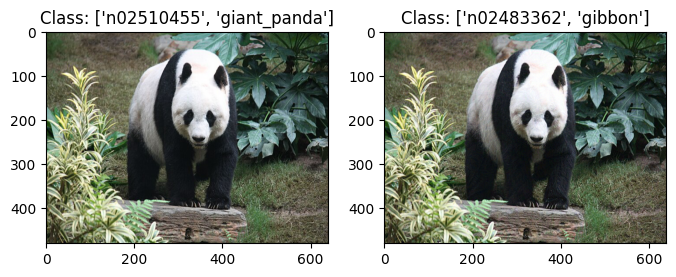

In [19]:
fig, axe = plt.subplots(1,2, figsize = (8,6))

crafted_image = adv_images[0].detach().permute(1,2,0).cpu().numpy()
original_image = torch_original.detach().permute(1,2,0).cpu().numpy()
axe[1].imshow(crafted_image)
crafted_class_name = class_idx[str(prediction)]
axe[1].set_title(f"Class: {crafted_class_name}")
axe[0].imshow(original_image)
axe[0].set_title(f"Class: {class_name}")